# 1. Explore the whole database
--------------------------------

In [ ]:
import duckdb

duckdb.close()

con = duckdb.connect("../database/cfpb_complaints.duckdb")

# Print the result of catalog and schema structure
result = con.execute("SELECT catalog_name, schema_name FROM information_schema.schemata;").fetchdf()
result

,catalog_name,schema_name
0,cfpb_complaints,intermediate
1,cfpb_complaints,main
2,cfpb_complaints,marts
3,cfpb_complaints,raw
4,cfpb_complaints,raw_staging
5,cfpb_complaints,staging
6,system,information_schema
7,system,main
8,system,pg_catalog
9,temp,main


So we focus on the catelog name of cfpb_complaints. Let go deeper on it!

We have 5 schemas:
1. raw - Raw data exactly as loaded
2. raw-staging - Lightly cleaned + typed versions of raw
3. staging - Business-ready standardized tables
4. intermediate - transformations combining multiple staging models
5. marts - final analytics tables for BI dashboards

However, with the purpose of building model, in this notebook we're gonna just focus on the 'raw' schema. Let explore it

## 1.1 raw

In [2]:
# Show tables in the raw schema
raw_tables = con.sql("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'raw'
    ORDER BY table_name;
""").df()
raw_tables

,table_name
0,_dlt_loads
1,_dlt_pipeline_state
2,_dlt_version
3,cfpb_complaints


In [3]:
# Explore each table
cfpb_complaints = con.sql("SELECT * FROM raw.cfpb_complaints LIMIT 3").df()
dlt_loads = con.sql("SELECT * FROM raw._dlt_loads LIMIT 3").df()
dlt_version = con.sql("SELECT * FROM raw._dlt_version LIMIT 3").df()
dlt_pipeline_state = con.sql("SELECT * FROM raw._dlt_pipeline_state LIMIT 3").df()

cfpb_complaints

,product,complaint_what_happened,date_sent_to_company,issue,sub_product,zip_code,complaint_id,timely,company_response,submitted_via,...,date_received,state,consumer_disputed,sub_issue,_dlt_extracted_at,_dlt_load_id,_dlt_id,consumer_consent_provided,tags,company_public_response
0,Credit reporting or other personal consumer re...,,2025-11-05 12:00:00-05:00,Incorrect information on your report,Credit reporting,30501,17054567,Yes,In progress,Web,...,2025-11-05 12:00:00-05:00,GA,N/A,Account status incorrect,2025-11-29 20:41:26.161918-05:00,1764484856.0932565,teTjViH620pbXQ,None,None,None
1,Credit card,,2025-10-02 13:00:00-04:00,Incorrect information on your report,General-purpose credit card or charge card,13021,16285565,Yes,In progress,Web,...,2025-10-02 13:00:00-04:00,NY,N/A,Information belongs to someone else,2025-11-29 20:41:50.988020-05:00,1764484898.746703,DCm8e3jj9OzUOA,None,None,None
2,Credit card,,2024-09-03 13:00:00-04:00,Getting a credit card,General-purpose credit card or charge card,02631,10000688,Yes,Closed with non-monetary relief,Postal mail,...,2024-09-03 13:00:00-04:00,MA,N/A,Card opened without my consent or knowledge,2025-12-04 15:00:26.649658-05:00,1764896401.92204,Ld/Hxv4D+ZxWwQ,N/A,None,None


In [4]:
con.sql("DESCRIBE raw.cfpb_complaints").df()

,column_name,column_type,null,key,default,extra
0,product,VARCHAR,YES,None,None,None
1,complaint_what_happened,VARCHAR,YES,None,None,None
2,date_sent_to_company,TIMESTAMP WITH TIME ZONE,YES,None,None,None
3,issue,VARCHAR,YES,None,None,None
4,sub_product,VARCHAR,YES,None,None,None
5,zip_code,VARCHAR,YES,None,None,None
6,complaint_id,VARCHAR,NO,None,None,None
7,timely,VARCHAR,YES,None,None,None
8,company_response,VARCHAR,YES,None,None,None
9,submitted_via,VARCHAR,YES,None,None,None


In [5]:
# Count number of complaints for each company
con.sql("""
    SELECT company, COUNT(*) AS total
    FROM raw.cfpb_complaints
    GROUP BY company
    ORDER BY total DESC
""").df()

,company,total
0,CAPITAL ONE FINANCIAL CORPORATION,68053
1,JPMORGAN CHASE & CO.,56003
2,WELLS FARGO & COMPANY,52658
3,"BANK OF AMERICA, NATIONAL ASSOCIATION",45185
4,"CITIBANK, N.A.",41131
...,...,...
63,Bank of Baroda - New York Branch,2
64,Secure One Capital Corporation,2
65,TCF NATIONAL BANK,1
66,"HUNTINGTON NATIONAL BANK, THE - FIRSTMERIT BAN...",1


In [6]:
# FILTER OUT 10 COMPANIES
companies = [
    "CAPITAL ONE FINANCIAL CORPORATION",
    "JPMORGAN CHASE & CO.",
    "WELLS FARGO & COMPANY",
    "BANK OF AMERICA, NATIONAL ASSOCIATION",
    "CITIBANK, N.A.",
    "U.S. BANCORP",
    "GOLDMAN SACHS BANK USA",
    "PNC Bank N.A.",
    "TRUIST FINANCIAL CORPORATION",
    "STATE STREET BANK AND TRUST COMPANY",
]

query = f"""
    SELECT company, COUNT(*) AS total
    FROM raw.cfpb_complaints
    WHERE company IN ({",".join([f"'{c}'" for c in companies])})
    GROUP BY company
    ORDER BY total DESC
"""

con.sql(query).df()

,company,total
0,CAPITAL ONE FINANCIAL CORPORATION,68053
1,JPMORGAN CHASE & CO.,56003
2,WELLS FARGO & COMPANY,52658
3,"BANK OF AMERICA, NATIONAL ASSOCIATION",45185
4,"CITIBANK, N.A.",41131
5,U.S. BANCORP,13519
6,GOLDMAN SACHS BANK USA,11972
7,TRUIST FINANCIAL CORPORATION,11936
8,PNC Bank N.A.,7690
9,STATE STREET BANK AND TRUST COMPANY,8


As State Street just has 8 complaints, which are not enough for modeling, we're gonna exclude that from our further working dataset

In [7]:
# Create the new table without State Street

companies = [
    "CAPITAL ONE FINANCIAL CORPORATION",
    "JPMORGAN CHASE & CO.",
    "WELLS FARGO & COMPANY",
    "BANK OF AMERICA, NATIONAL ASSOCIATION",
    "CITIBANK, N.A.",
    "U.S. BANCORP",
    "GOLDMAN SACHS BANK USA",
    "PNC Bank N.A.",
    "TRUIST FINANCIAL CORPORATION",
]

query = f"""
    CREATE OR REPLACE TABLE eda_complaints AS
    SELECT *
    FROM raw.cfpb_complaints
    WHERE company IN ({",".join([f"'{c}'" for c in companies])})
"""

con.sql(query)

con.close()

# 2. Problem and EDA
---------------------

In this note book, we gonna use the dataset we ingested to predict the company response based on given predicted variables => This is a classification problem

## 2.1 Explore the dataset

In [8]:
con = duckdb.connect("../database/cfpb_complaints.duckdb")

In [9]:
con.sql("""
SELECT COUNT(*) as total_rows
FROM eda_complaints;
""").df()

,total_rows
0,308147


In [10]:
con.sql("""
DESCRIBE eda_complaints;
""").df()

,column_name,column_type,null,key,default,extra
0,product,VARCHAR,YES,None,None,None
1,complaint_what_happened,VARCHAR,YES,None,None,None
2,date_sent_to_company,TIMESTAMP WITH TIME ZONE,YES,None,None,None
3,issue,VARCHAR,YES,None,None,None
4,sub_product,VARCHAR,YES,None,None,None
5,zip_code,VARCHAR,YES,None,None,None
6,complaint_id,VARCHAR,YES,None,None,None
7,timely,VARCHAR,YES,None,None,None
8,company_response,VARCHAR,YES,None,None,None
9,submitted_via,VARCHAR,YES,None,None,None


Based on these variables above, we're critically gonna choose appropriates variables for our prediction problem

**Response variable**
- *company_response*

**Predicted variables**
- *product*
- *issue*
- *sub_product*
- *sub_issue*
- *company*
- *state*
- *zip_code*
- *submitted_via*
- *consumer_consent_provided*
- *tags*

## 2.2 Explore each variable

In [11]:
# Create a DataFrame
df = con.sql("""
    SELECT *,
    DATE_DIFF('hour', date_received, date_sent_to_company) AS response_time_days

    FROM eda_complaints;
""").df()

### 2.2.1 product

In [ ]:
# Count values
print(df["product"].value_counts())

print(df["product"].nunique())

product
Checking or savings account                                                     96398
Credit card                                                                     67626
Credit reporting or other personal consumer reports                             61893
Debt collection                                                                 17855
Credit card or prepaid card                                                     14908
Money transfer, virtual currency, or money service                              14525
Mortgage                                                                        12131
Credit reporting, credit repair services, or other personal consumer reports    11297
Vehicle loan or lease                                                            7283
Prepaid card                                                                     2091
Payday loan, title loan, personal loan, or advance loan                          1201
Debt or credit management                     

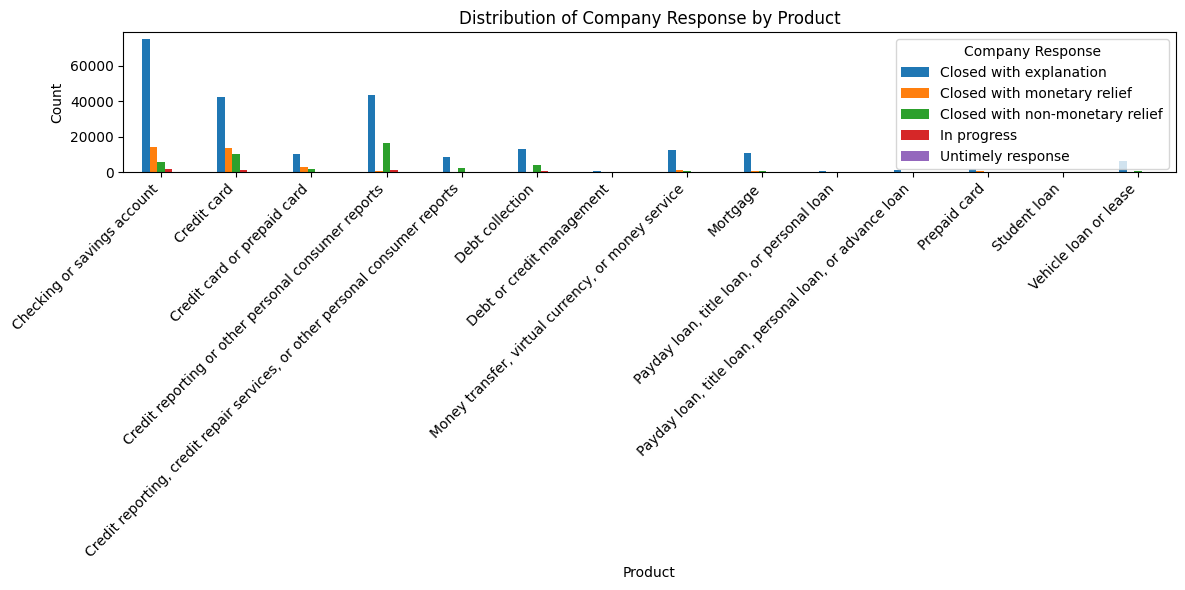

In [13]:
# Grouped Bar Chart
import matplotlib.pyplot as plt
import pandas as pd

pd.crosstab(df["product"], df["company_response"]).plot(kind="bar", figsize=(12, 6))
plt.title("Distribution of Company Response by Product")
plt.xlabel("Product")
plt.ylabel("Count")
plt.legend(title="Company Response")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [14]:
# Check null value
df["product"].isnull().sum()

0

The distribution of the *'product'* include more value in the group of *'Checking or savings account'*. But totally, it does not really affect our whole variable. And because we have 14 unique categorical values for this variable which are not too many, we're gonna apply the **one-hot encoding** method

### 2.2.2 sub_product

In [15]:
# Count values
print(df["sub_product"].value_counts())

print(df["sub_product"].nunique())

sub_product
Checking account                                    80118
General-purpose credit card or charge card          75758
Credit reporting                                    71914
Credit card debt                                     8977
Savings account                                      8429
Conventional home mortgage                           7394
Domestic (US) money transfer                         6976
Loan                                                 6858
I do not know                                        6599
Store credit card                                    6080
Other banking product or service                     5942
Mobile or digital wallet                             2979
FHA mortgage                                         2149
International money transfer                         1964
CD (Certificate of Deposit)                          1905
Government benefit card                              1699
Home equity loan or line of credit (HELOC)           1440
Ot

In [16]:
pd.crosstab(df["sub_product"], df["company_response"])

company_response,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,In progress,Untimely response
sub_product,,,,,
Auto debt,851,7,62,16,0
CD (Certificate of Deposit),1580,194,113,18,0
Check cashing service,437,34,31,6,0
Checking account,62017,11958,4878,1262,3
Conventional home mortgage,6563,303,425,103,0
Credit card debt,6532,150,2139,155,1
Credit repair services,169,10,37,3,0
Credit reporting,51063,677,18867,1303,3
Debt settlement,238,25,14,6,0


In [17]:
# Check null values
df["sub_product"].isnull().sum()

3

In [18]:
# Handle null value to 'I do not know'
df.fillna({"sub_product": "I do not know"}, inplace=True)

For this variable, it is also a categorical variable. However, it includes 58 unique values which is a huge number that we should not apply opne-hot encoding to. We're gonna use another method which is **Target Encoding**

### 2.2.3 issue

In [19]:
print(df["issue"].value_counts())

print(df["issue"].nunique())

issue
Managing an account                                  56553
Incorrect information on your report                 34588
Improper use of your report                          30630
Problem with a purchase shown on your statement      24966
Closing an account                                   13845
                                                     ...  
Vehicle was repossessed or sold the vehicle              3
Unexpected fees                                          2
Issue where my lender is my school                       2
Was approved for a loan, but didn't receive money        1
Vehicle was damaged or destroyed the vehicle             1
Name: count, Length: 87, dtype: int64
87


In [20]:
# Create a crosstab (their categorical distribution) between 'issue' and 'compnay_response'
pd.crosstab(df["issue"], df["company_response"])

company_response,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,In progress,Untimely response
issue,,,,,
Advertising,25,12,3,0,0
"Advertising and marketing, including promotional offers",2576,606,493,48,0
Applying for a mortgage or refinancing an existing mortgage,1584,54,52,21,0
Attempts to collect debt not owed,5372,138,1824,226,0
Can't contact lender or servicer,10,0,1,0,0
...,...,...,...,...,...
Vehicle was repossessed or sold the vehicle,2,1,0,0,0
"Was approved for a loan, but didn't receive money",1,0,0,0,0
"Was approved for a loan, but didn't receive the money",6,0,0,0,0


In [21]:
# Check null value
df["issue"].isnull().sum()

3

In [22]:
# Handle null value by excluding them
df = df[df["issue"].notna()]

We have 87 unique values for this variables, so we will use the same method from the latest part which is **target encoding**

### 2.2.4 sub_issue

In [23]:
print(df["sub_issue"].value_counts())

print(df["sub_issue"].nunique())

sub_issue
Deposits and withdrawals                                                            21954
Credit card company isn't resolving a dispute about a purchase on your statement    18179
Reporting company used your report improperly                                       17951
Information belongs to someone else                                                 12992
Credit inquiries on your report that you don't recognize                            12276
                                                                                    ...  
Problem with your payment plan                                                          2
Problem extending the lease                                                             2
Issues with financial aid services                                                      1
Co-signer                                                                               1
Was signed up for overdraft on card, but don't want to be                               1


There are too many sub_issue's unique values (205) which is a huge amount of number. Additionally, we also have issue variable included in our model, as a result, we can exclude this variable. 

### 2.2.5 company 

In [24]:
# We know that we have 9 companies
# Check its distribution
pd.crosstab(df["company"], df["company_response"])

company_response,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,In progress,Untimely response
company,,,,,
"BANK OF AMERICA, NATIONAL ASSOCIATION",29178,10596,3460,1937,13
CAPITAL ONE FINANCIAL CORPORATION,54003,3214,9590,1246,0
"CITIBANK, N.A.",21016,7599,12315,201,0
GOLDMAN SACHS BANK USA,8095,1581,2284,12,0
JPMORGAN CHASE & CO.,45889,3838,5867,408,0
PNC Bank N.A.,6374,762,72,482,0
TRUIST FINANCIAL CORPORATION,10422,540,682,292,0
U.S. BANCORP,8136,1365,3881,137,0
WELLS FARGO & COMPANY,42575,4119,5305,657,0


We just have 9 unique categorical values, we can apply **one hot encoding**

### 2.2.6 state

In [25]:
print(df["state"].value_counts())

print(df["state"].nunique())

state
CA                                      47261
FL                                      33872
TX                                      28328
NY                                      24130
GA                                      17429
IL                                      13004
NJ                                      11944
PA                                      10983
NC                                       9676
MD                                       8064
VA                                       7910
OH                                       6815
AZ                                       6600
MI                                       6463
MA                                       5441
WA                                       4939
NV                                       4876
SC                                       4429
CO                                       4187
TN                                       4052
LA                                       3465
CT                          

It should be 59, what is the another one? Let try to find it

In [26]:
valid_states = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "FL",
    "GA",
    "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
    "DC",
]

territories = ["PR", "GU", "VI", "AS", "MP"]

military = ["AE", "AP", "AA"]

all_states = set(df["state"].dropna().unique())
invalid_states = [
    s for s in all_states if s not in valid_states and s not in territories and s not in military
]

invalid_states

['UNITED STATES MINOR OUTLYING ISLANDS']

*United States Minor Outlying Islands* is not a valid state => still **keep** it

In [27]:
# Check null value
df["state"].isnull().sum()

2042

In [28]:
# As we have 2042 null value, let filter it out
df = df[df["state"].notna()]

As we have 60 unique values, the *state" variable can be applied **target encoding**

### 2.2.7 zip_code

In [29]:
# Check missing
df["zip_code"].isnull().sum()

5

In [30]:
# Check unique values
df["zip_code"].nunique()

16450

As in the US, there are around more than 42000 zip code while in our dataset just has 16450. Also, we has the *state* variable => Do not have to use this variable (Exclude)

### 2.2.8 submitted_via

In [31]:
df["submitted_via"].value_counts()

submitted_via
Web             278505
Phone            13144
Referral         11728
Postal mail       2555
Web Referral       170
Name: count, dtype: int64

In [32]:
# Check distribution
pd.crosstab(df["submitted_via"], df["company_response"])

company_response,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,In progress,Untimely response
submitted_via,,,,,
Phone,10001,1931,1116,96,0
Postal mail,1968,315,233,39,0
Referral,8763,1913,817,235,0
Web,203173,29245,41109,4965,12
Web Referral,134,23,13,0,0


In [33]:
df["submitted_via"].isnull().sum()

0

*Submitted_via* variable has 5 unique values, so we will use **one hot encoding**

### 2.2.9 consumer_consent_provided

In [34]:
df["consumer_consent_provided"].value_counts()

consumer_consent_provided
Consent provided        152069
Consent not provided    104578
N/A                      27427
Other                     7024
Consent withdrawn         1256
Name: count, dtype: int64

In [35]:
pd.crosstab(df["consumer_consent_provided"], df["company_response"])

company_response,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,In progress,Untimely response
consumer_consent_provided,,,,,
Consent not provided,76314,8533,19428,302,1
Consent provided,112870,19427,19414,347,11
Consent withdrawn,879,177,178,22,0
N/A,20732,4159,2166,370,0
Other,5382,622,891,128,0


In [36]:
df["consumer_consent_provided"].isnull().sum()

13748

In [37]:
df = df[df["consumer_consent_provided"].notna()]

With 5 unique values, **one hot encoding** will be applied to this variable

### 2.2.10 consumer_disputed

In [38]:
pd.crosstab(df["consumer_disputed"], df["company_response"])

company_response,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,In progress,Untimely response
consumer_disputed,,,,,
N/A,216177,32918,42077,1169,12


Look at the the crosstab above, this variable does not bring any meaningful insight. We will exclude this variable from our prediction

### 2.2.11 tags

In [39]:
pd.crosstab(df["tags"], df["company_response"])

company_response,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,In progress,Untimely response
tags,,,,,
Older American,14647,3558,1916,74,1
"Older American, Servicemember",3804,804,512,18,0
Servicemember,13683,1792,2600,42,1


In [40]:
df["tags"].isnull().sum()

248902

Our dataset has around 300K data points while this variable has nearly 250K of missing values, which is too serious and hard to sacrify to hanlde them. We're gonna exclude this from our prediction, too

### 2.2.12 company_response (response variable)

In [41]:
# Count values
print(df["company_response"].value_counts())

print(df["company_response"].nunique())

company_response
Closed with explanation            216177
Closed with non-monetary relief     42077
Closed with monetary relief         32918
In progress                          1169
Untimely response                      12
Name: count, dtype: int64
5


In [42]:
df["company_response"].isnull().sum()

1

In [43]:
df = df[df["company_response"].notna()]

In [44]:
# Because the value of 'In progress' and 'Untimely response' will not bring any meaning to our model, we will filter out our dataset from these 2 results
df = df[(df["company_response"] != "In progress")]
df = df[(df["company_response"] != "Untimely response")]

print(len(df))

291172


### 2.2.13 Handle missing values and extract necessary columns to our final DataFrame

In [45]:
df = df[
    [
        "product",
        "issue",
        "sub_product",
        "company",
        "state",
        "submitted_via",
        "consumer_consent_provided",
        "company_response",
    ]
]

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291172 entries, 0 to 308146
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   product                    291172 non-null  object
 1   issue                      291172 non-null  object
 2   sub_product                291172 non-null  object
 3   company                    291172 non-null  object
 4   state                      291172 non-null  object
 5   submitted_via              291172 non-null  object
 6   consumer_consent_provided  291172 non-null  object
 7   company_response           291172 non-null  object
dtypes: object(8)
memory usage: 20.0+ MB


In [47]:
df.head()

,product,issue,sub_product,company,state,submitted_via,consumer_consent_provided,company_response
0,Checking or savings account,Problem with a lender or other company chargin...,Checking account,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,Web,Consent provided,Closed with explanation
1,Checking or savings account,Problem caused by your funds being low,Checking account,"BANK OF AMERICA, NATIONAL ASSOCIATION",NJ,Web,Consent provided,Closed with explanation
2,Credit reporting or other personal consumer re...,Improper use of your report,Credit reporting,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,Web,Consent not provided,Closed with explanation
3,Credit reporting or other personal consumer re...,Improper use of your report,Credit reporting,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,Web,Consent not provided,Closed with explanation
4,Credit card,Problem with a purchase shown on your statement,General-purpose credit card or charge card,U.S. BANCORP,MA,Phone,N/A,Closed with explanation


# 3. Encoding

Let re-state which variables are applied by which method:
- *product*: onehot_encoding
- *sub_product*: target_encoding
- *issue*: target_encoding
- *company*: onehot_encoding
- *state*: target_encoding
- *submitted_via*: onehot_encoding
- *consumer_consent_provided*: onehot_encoding


## 3.1 Split the data

In [48]:
import os

import pandas as pd
from sklearn.model_selection import train_test_split

# Ensure folder exists
os.makedirs("../database/ML", exist_ok=True)

# Your dataframe after filtering the 10 companies
df_clean = df.copy()

X = df_clean.drop("company_response", axis=1)
y = df_clean["company_response"]

# Split 70% train, 30% temp
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

# Convert to DataFrame
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 203820
Test size: 87352


## 3.2 Encoding Pipeline

In [49]:
import os

import duckdb
import pandas as pd
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

### 3.2.1 Define columns for each encoding type


In [50]:
onehot_cols = ["product", "company", "submitted_via", "consumer_consent_provided"]

target_cols = ["sub_product", "issue", "state"]

### 3.2.2 ColumnsTrandformer process

In [51]:
# One-hot encoding
onehot_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Target encoding
target_transformer = Pipeline(steps=[("target", TargetEncoder())])

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ("ohe", onehot_transformer, onehot_cols),
        ("te", target_transformer, target_cols),
    ],
    remainder="passthrough",
)

### 3.2.3 Fit and Transform

In [ ]:
import os

import joblib
import pandas as pd

# Check if it's a sparse matrix
from scipy import sparse
from sklearn.preprocessing import LabelEncoder

# Transform
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
print(f"Shape X_train: {X_train_transformed.shape}")

X_test_transformed = preprocessor.transform(X_test)
print(f"Shape X_test: {X_test_transformed.shape}")

feature_names = preprocessor.get_feature_names_out()

if sparse.issparse(X_train_transformed):
    print("X_train_transformed is sparse matrix!")
    X_train_transformed = X_train_transformed.toarray()
    X_test_transformed = X_test_transformed.toarray()
    print(f"Converted to dense array. New shape: {X_train_transformed.shape}")

X_train_final_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_final_df = pd.DataFrame(X_test_transformed, columns=feature_names)


# Label Encoder for the response variable
# Transform y for classification

le = LabelEncoder()

# Fit and transform the training target, transform the test target
# This converts 'Yes'/'No' (or other categories) into 1/0
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train = pd.DataFrame(y_train_encoded, columns=["company_response"])
y_test = pd.DataFrame(y_test_encoded, columns=["company_response"])

Shape X_train: (203820, 36)
Shape X_test: (87352, 36)
⚠️ X_train_transformed is sparse matrix!
Converted to dense array. New shape: (203820, 36)


/home/hoan/VSCode/projects/local_elt_pipeline/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoan/VSCode/projects/local_elt_pipeline/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### 3.2.4 Save the splitted dataset, pipeline (Encoding and Response Transformer)

In [54]:
os.makedirs("../src/models", exist_ok=True)
joblib.dump(preprocessor, "../src/models/preprocessor.pkl")

joblib.dump(le, "../src/models/target_label_encoder.pkl")

['../src/models/target_label_encoder.pkl']

In [55]:
# Save X
con = duckdb.connect("../database/ML/X_train.duckdb")
con.execute("CREATE OR REPLACE TABLE X_train AS SELECT * FROM X_train_final_df")
con.close()

con = duckdb.connect("../database/ML/X_test.duckdb")
con.execute("CREATE OR REPLACE TABLE X_test AS SELECT * FROM X_test_final_df")
con.close()

# Save y
con = duckdb.connect("../database/ML/y_train.duckdb")
# Rename the pandas variable in the query context to avoid confusion
con.register("y_train_df", y_train)
con.execute("CREATE OR REPLACE TABLE y_train AS SELECT * FROM y_train_df")
con.close()

con = duckdb.connect("../database/ML/y_test.duckdb")
con.register("y_test_df", y_test)
con.execute("CREATE OR REPLACE TABLE y_test AS SELECT * FROM y_test_df")
con.close()